In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# CMYK
r = 2**np.arange(7)/80
print(r)

[0.0125 0.025  0.05   0.1    0.2    0.4    0.8   ]


In [2]:
def dict_to_rmse(scores_dict):
    rmse = np.empty((2,len(scores_dict)))
    for i,s in enumerate(scores_dict):
        rmse[0,i] = s['rmse mean']
        rmse[1,i] = s['rmse std']
    return rmse

def dict_to_auc(scores_dict):
    auc = np.empty((2,len(scores_dict)))
    for i,s in enumerate(scores_dict):
        auc[0,i] = s['auc mean']
        auc[1,i] = s['auc std']
    return auc

# Physical chemistry
## ESOL

In [72]:
scores_st = [
{'r2 mean': -0.9415211583946711, 'r2 std': 1.318261575180566, 'rmse mean': 1.7908540396408246, 'rmse std': 0.25921653824603286},
{'r2 mean': 0.21987364024785078, 'r2 std': 0.26423711932535426, 'rmse mean': 1.410556424185161, 'rmse std': 0.1619803398915317},
{'r2 mean': 0.5128095467248189, 'r2 std': 0.1132851494485317, 'rmse mean': 1.234851956578455, 'rmse std': 0.07711254483544838},
{'r2 mean': 0.7058795568941922, 'r2 std': 0.03971447217797195, 'rmse mean': 1.0560405630256362, 'rmse std': 0.05393620743155319},
{'r2 mean': 0.7866785226815878, 'r2 std': 0.017868447395329307, 'rmse mean': 0.917584585105155, 'rmse std': 0.03221614644383914},
{'r2 mean': 0.8296558843447276, 'r2 std': 0.014470207869228075, 'rmse mean': 0.8354456598643283, 'rmse std': 0.02723549825579435},
{'r2 mean': 0.8486505017697061, 'r2 std': 0.020569941384336946, 'rmse mean': 0.761559990373766, 'rmse std': 0.031738224491864524}
]
scores_ecfp = [
{'r2 mean': -4.7402112859348495, 'r2 std': 3.1798477948327104, 'rmse mean': 2.188672097366932, 'rmse std': 0.18940337551323744},
{'r2 mean': -1.384854403530391, 'r2 std': 0.9081951082252677, 'rmse mean': 2.0080312778492266, 'rmse std': 0.15757048826985784},
{'r2 mean': -0.5985494464085359, 'r2 std': 0.38650140129593413, 'rmse mean': 1.7864592440979798, 'rmse std': 0.10786081803605932},
{'r2 mean': -0.02718075663062469, 'r2 std': 0.2135168394311371, 'rmse mean': 1.7065199955745922, 'rmse std': 0.09770963048160494},
{'r2 mean': 0.260069398629162, 'r2 std': 0.11817211221207023, 'rmse mean': 1.5906690083311514, 'rmse std': 0.08374865657744206},
{'r2 mean': 0.4614631358425701, 'r2 std': 0.04028213510301852, 'rmse mean': 1.4976970335858346, 'rmse std': 0.0612324267460719},
{'r2 mean': 0.5507400136089835, 'r2 std': 0.061647391891406826, 'rmse mean': 1.4092443428232408, 'rmse std': 0.10031545693821599}
]
scores_rnn = [
{'r2 mean': -0.6576655351343479, 'r2 std': 0.8680374730965782, 'rmse mean': 1.834342726508901, 'rmse std': 0.21592843037541112},
{'r2 mean': 0.14646331766402304, 'r2 std': 0.2236021043686714, 'rmse mean': 1.6208138023522753, 'rmse std': 0.1268105200308446},
{'r2 mean': 0.41538372045048283, 'r2 std': 0.11580891603843564, 'rmse mean': 1.5152292646131922, 'rmse std': 0.1363634279973064},
{'r2 mean': 0.6089665447946749, 'r2 std': 0.06490939719166545, 'rmse mean': 1.2774097842323777, 'rmse std': 0.06573541382128653},
{'r2 mean': 0.6437542811598538, 'r2 std': 0.051977240501511576, 'rmse mean': 1.1091943179563248, 'rmse std': 0.05354884488129093},
{'r2 mean': 0.7235049897986274, 'r2 std': 0.04045275472829479, 'rmse mean': 0.986976386963035, 'rmse std': 0.0655700862348413},
{'r2 mean': 0.7906370184206036, 'r2 std': 0.043821997826166144, 'rmse mean': 0.8767984719438366, 'rmse std': 0.08130190297818693}
]
scores_gc = [
{'r2 std': 0.13731069505536772, 'rmse mean': 2.038118873034943, 'rmse std': 0.13708272776853087, 'r2 mean': 0.0492170198297721},
{'r2 std': 0.15219166980381274, 'rmse mean': 2.0360997494080744, 'rmse std': 0.1539481708590541, 'r2 mean': 0.050446135350850296},
{'r2 std': 0.05926625731698256, 'rmse mean': 1.980477834175543, 'rmse std': 0.06386098036042964, 'r2 mean': 0.10292860963188007},
{'r2 std': 0.06627668325883922, 'rmse mean': 1.801430254112325, 'rmse std': 0.08203456830789985, 'r2 mean': 0.25695585907475416},
{'r2 std': 0.07676889592754332, 'rmse mean': 1.5853024331790908, 'rmse std': 0.105235258456058, 'r2 mean': 0.420912889862436},
{'r2 std': 0.07503913819702494, 'rmse mean': 1.2871543898820907, 'rmse std': 0.12349047998018856, 'r2 mean': 0.6199707421473404},
{'r2 std': 0.03856128227181201, 'rmse mean': 0.9791805406567875, 'rmse std': 0.07992652892805012, 'r2 mean': 0.7775187081294384}
]
scores_bert = [
{'r2 mean': -0.4218462598319155, 'r2 std': 1.12853220433728, 'rmse mean': 1.8052634864354444, 'rmse std': 0.20438272367625782},
{'r2 mean': 0.32471180816709816, 'r2 std': 0.2468824590116601, 'rmse mean': 1.5369117436060828, 'rmse std': 0.17608701970619678},
{'r2 mean': 0.5334642440236695, 'r2 std': 0.1092973853906982, 'rmse mean': 1.3221119866010917, 'rmse std': 0.07127253124107574},
{'r2 mean': -0.9310922138484308, 'r2 std': 5.276265447966326, 'rmse mean': 1.3095256093518166, 'rmse std': 0.48243167949379884},
{'r2 mean': 0.5688103712394028, 'r2 std': 0.05505722514619573, 'rmse mean': 1.1528883875727645, 'rmse std': 0.05836515215097479},
{'r2 mean': 0.6440640882746392, 'r2 std': 0.05735699050993663, 'rmse mean': 1.0766792279748891, 'rmse std': 0.07766064735586084},
{'r2 mean': 0.7268476273394718, 'r2 std': 0.06532608897634908, 'rmse mean': 0.9441091512413504, 'rmse std': 0.08121336523946884}
]

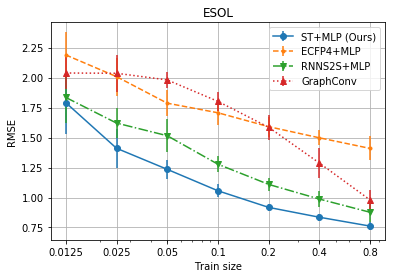

In [73]:
plt.figure(figsize=(6,4))
res_1_1 = dict_to_rmse(scores_st)
res_1_2 = dict_to_rmse(scores_ecfp)
res_1_3 = dict_to_rmse(scores_rnn)
res_1_4 = dict_to_rmse(scores_gc)
res_1_5 = dict_to_rmse(scores_bert)
plt.errorbar(r, res_1_1[0], yerr=res_1_1[1], fmt='o-', label='ST+MLP (Ours)')
plt.errorbar(r, res_1_2[0], yerr=res_1_2[1], fmt='.--', label='ECFP4+MLP')
plt.errorbar(r, res_1_3[0], yerr=res_1_3[1], fmt='v-.', label='RNNS2S+MLP')
plt.errorbar(r, res_1_4[0], yerr=res_1_4[1], fmt='^:', label='GraphConv')
#plt.errorbar(r, res_1_5[0], yerr=res_1_5[1], fmt='o-', label='')
plt.xlabel('Train size')
plt.ylabel('RMSE')
plt.xscale('log')
plt.xticks(r, r)
plt.title('ESOL')
plt.legend()
plt.grid()
plt.show()

In [30]:
print('ST+MLP (Ours):', np.mean(rmse_1[0]))
print('ECFP4+MLP    :', np.mean(rmse_2[0]))
print('RNNS2S+MLP   :', np.mean(rmse_3[0]))
print('GraphConv    :', np.mean(rmse_4[0]))
print('BertFP+MLP   :', np.mean(rmse_5[0]))

ST+MLP (Ours): 1.1438418883961894
ECFP4+MLP    : 1.741041857089851
RNNS2S+MLP   : 1.317252107795706
GraphConv    : 1.6725377249212647
BertFP+MLP   : 1.3067842275404915


## FreeSolv

In [74]:
scores_st = [
{'r2 mean': -2.576038848307165, 'r2 std': 3.1823582514133255, 'rmse mean': 3.563285984573214, 'rmse std': 0.5203207480476947},
{'r2 mean': -0.17155490859900016, 'r2 std': 0.6497953698039862, 'rmse mean': 3.017973895559536, 'rmse std': 0.26276075872191623},
{'r2 mean': 0.16950231130627935, 'r2 std': 0.30159171397738704, 'rmse mean': 2.708900454757266, 'rmse std': 0.17872391432042722},
{'r2 mean': 0.5122244255315207, 'r2 std': 0.1402954987278971, 'rmse mean': 2.2807329472406654, 'rmse std': 0.23637379910082748},
{'r2 mean': 0.6388957316544357, 'r2 std': 0.09057368881510199, 'rmse mean': 2.0964547983650728, 'rmse std': 0.1717243453332883},
{'r2 mean': 0.7494189701158778, 'r2 std': 0.06984317995358243, 'rmse mean': 1.752377868341597, 'rmse std': 0.17197715801020766},
{'r2 mean': 0.822875714266269, 'r2 std': 0.03297363529141653, 'rmse mean': 1.5651345339616252, 'rmse std': 0.12273727507018312}
]
scores_ecfp = [
{'r2 mean': -8.249829514981576, 'r2 std': 5.155942727909447, 'rmse mean': 3.7731531040381254, 'rmse std': 0.29264932692192236},
{'r2 mean': -6.608540315598347, 'r2 std': 5.124543664210768, 'rmse mean': 3.741884029649259, 'rmse std': 0.3574978874792624},
{'r2 mean': -2.7724693760067467, 'r2 std': 1.141712601756891, 'rmse mean': 3.495406561344887, 'rmse std': 0.2279989969923611},
{'r2 mean': -0.6963197306733483, 'r2 std': 0.5087077522223022, 'rmse mean': 3.0379101054168234, 'rmse std': 0.18784217858626967},
{'r2 mean': 0.043597037881702425, 'r2 std': 0.2739795675995701, 'rmse mean': 2.701847249065082, 'rmse std': 0.22920512171513513},
{'r2 mean': 0.43908453408517223, 'r2 std': 0.2005841073724038, 'rmse mean': 2.319037238029083, 'rmse std': 0.26535652438656315},
{'r2 mean': 0.5825636720130783, 'r2 std': 0.15797881956329185, 'rmse mean': 2.229430763600421, 'rmse std': 0.32842121152455583}
]
scores_rnn = [
{'r2 mean': -1.615745596115613, 'r2 std': 1.30363754084909, 'rmse mean': 3.7720689486018535, 'rmse std': 0.33779178449363345},
{'r2 mean': -0.796930834007093, 'r2 std': 1.0379189493195213, 'rmse mean': 3.8487613943533794, 'rmse std': 0.40999173919011167},
{'r2 mean': -0.04056501696922476, 'r2 std': 0.3129901234962947, 'rmse mean': 3.461297109364863, 'rmse std': 0.31524635484683333},
{'r2 mean': 0.27739675155942656, 'r2 std': 0.1898138070408286, 'rmse mean': 2.939124192135112, 'rmse std': 0.1752893508268099},
{'r2 mean': 0.46804150937809774, 'r2 std': 0.09206445928415609, 'rmse mean': 2.5907312336675123, 'rmse std': 0.16733094825672618},
{'r2 mean': 0.5422847453216633, 'r2 std': 0.08811908127393377, 'rmse mean': 2.2139400314097264, 'rmse std': 0.1312437049628559},
{'r2 mean': 0.6018561755802786, 'r2 std': 0.09849124916576087, 'rmse mean': 2.0804367851436165, 'rmse std': 0.22935096310462355}
]
scores_gc = [
{'r2 std': 0.14899402342251994, 'rmse mean': 3.850914631565682, 'rmse std': 0.26931897739166977, 'r2 mean': -0.007336469887074754},
{'r2 std': 0.0877068478375904, 'rmse mean': 3.6959999644207544, 'rmse std': 0.18293418015937568, 'r2 mean': 0.07240129030892695},
{'r2 std': 0.055684798942738874, 'rmse mean': 3.6843657391379785, 'rmse std': 0.1092416676948551, 'r2 mean': 0.08290928326789651},
{'r2 std': 0.0766076391442001, 'rmse mean': 3.6825427192897187, 'rmse std': 0.16435645017306705, 'r2 mean': 0.08806181577394037},
{'r2 std': 0.05107027917869597, 'rmse mean': 3.510427838117264, 'rmse std': 0.1203533872752387, 'r2 mean': 0.16543970752177256},
{'r2 std': 0.0502189235287458, 'rmse mean': 3.27297934293444, 'rmse std': 0.23114447078819533, 'r2 mean': 0.27353425159158135},
{'r2 std': 0.10159588836838618, 'rmse mean': 2.635496170324855, 'rmse std': 0.3742098146981473, 'r2 mean': 0.5323887535287921}
]
scores_bert = [
{'r2 mean': -1.377142007663866, 'r2 std': 1.5487518294971385, 'rmse mean': 3.6786090757959555, 'rmse std': 0.4631547029092409},
{'r2 mean': -0.5120257814567901, 'r2 std': 0.9416595926594606, 'rmse mean': 3.521783696845348, 'rmse std': 0.48660933002580875},
{'r2 mean': 0.09436097224372444, 'r2 std': 0.25540669155947027, 'rmse mean': 3.231243059431307, 'rmse std': 0.3850266360269509},
{'r2 mean': 0.25376523340854945, 'r2 std': 0.3189437279151671, 'rmse mean': 2.874012673776751, 'rmse std': 0.3734029890427589},
{'r2 mean': 0.4903933724769975, 'r2 std': 0.09405450015168304, 'rmse mean': 2.418033377941923, 'rmse std': 0.14287733130912234},
{'r2 mean': 0.3989386970916471, 'r2 std': 0.1935410242545029, 'rmse mean': 2.314307600743562, 'rmse std': 0.26585326818512867},
{'r2 mean': 0.4790413721629361, 'r2 std': 0.23232464064952593, 'rmse mean': 2.194148467402316, 'rmse std': 0.4054882828477564}
]

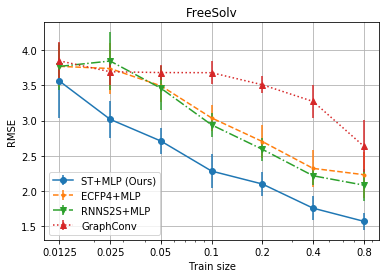

In [75]:
plt.figure(figsize=(6,4))
res_2_1 = dict_to_rmse(scores_st)
res_2_2 = dict_to_rmse(scores_ecfp)
res_2_3 = dict_to_rmse(scores_rnn)
res_2_4 = dict_to_rmse(scores_gc)
res_2_5 = dict_to_rmse(scores_bert)
plt.errorbar(r, res_2_1[0], yerr=res_2_1[1], fmt='o-', label='ST+MLP (Ours)')
plt.errorbar(r, res_2_2[0], yerr=res_2_2[1], fmt='.--', label='ECFP4+MLP')
plt.errorbar(r, res_2_3[0], yerr=res_2_3[1], fmt='v-.', label='RNNS2S+MLP')
plt.errorbar(r, res_2_4[0], yerr=res_2_4[1], fmt='^:', label='GraphConv')
#plt.errorbar(r, res_2_5[0], yerr=res_2_5[1], fmt='o-', label='')
plt.xlabel('Train size')
plt.ylabel('RMSE')
plt.xscale('log')
plt.xticks(r, r)
plt.title('FreeSolv')
plt.legend()
plt.grid()
plt.show()

In [41]:
print('ST+MLP (Ours):', np.mean(rmse_1[0]))
print('ECFP4+MLP    :', np.mean(rmse_2[0]))
print('RNNS2S+MLP   :', np.mean(rmse_3[0]))
print('GraphConv    :', np.mean(rmse_4[0]))
print('BertFP+MLP   :', np.mean(rmse_5[0]))

ST+MLP (Ours): 2.4264086403998535
ECFP4+MLP    : 3.0426670073062403
RNNS2S+MLP   : 2.986622813525152
GraphConv    : 3.4761037722558137
BertFP+MLP   : 2.890305421705309


## Lipophilicity

In [76]:
scores_st = [
{'r2 mean': -0.8554874389638881, 'r2 std': 0.32161227959529265, 'rmse mean': 1.362699506951056, 'rmse std': 0.05460045647733459},
{'r2 mean': -0.5750715666569235, 'r2 std': 0.23125835199131015, 'rmse mean': 1.3158578150223024, 'rmse std': 0.05672943297760686},
{'r2 mean': -0.9279695224423072, 'r2 std': 0.4063446132498258, 'rmse mean': 1.1688094071981658, 'rmse std': 0.036778880094887605},
{'r2 mean': -0.5248859235512959, 'r2 std': 0.21055122799288017, 'rmse mean': 1.1393706154991743, 'rmse std': 0.050638470682191},
{'r2 mean': -0.17559338156403226, 'r2 std': 0.08010647791343767, 'rmse mean': 1.1237959263208617, 'rmse std': 0.02691822224201018},
{'r2 mean': -0.06963317783051187, 'r2 std': 0.0718535871852915, 'rmse mean': 1.0619550410370049, 'rmse std': 0.03224306817213578},
{'r2 mean': 0.09709484977886422, 'r2 std': 0.10567680471645093, 'rmse mean': 1.010608821729128, 'rmse std': 0.043589502538406835}
]
scores_ecfp = [
{'r2 mean': -3.0185287752744396, 'r2 std': 0.5130118823343891, 'rmse mean': 1.2557652975680362, 'rmse std': 0.03034256405123591},
{'r2 mean': -1.8354626225369692, 'r2 std': 0.4250827781919392, 'rmse mean': 1.210881631299388, 'rmse std': 0.02872279543186055},
{'r2 mean': -1.1133476482277398, 'r2 std': 0.1432101923255158, 'rmse mean': 1.168687033147242, 'rmse std': 0.02132440870064626},
{'r2 mean': -0.5659144583266428, 'r2 std': 0.10375012951843238, 'rmse mean': 1.1244923947071837, 'rmse std': 0.02834369440099355},
{'r2 mean': -0.16426510220074525, 'r2 std': 0.0692734606243446, 'rmse mean': 1.0509783346213428, 'rmse std': 0.024879478637870336},
{'r2 mean': 0.10966450577713807, 'r2 std': 0.03768060588141019, 'rmse mean': 0.9624406906992293, 'rmse std': 0.014897447369411924},
{'r2 mean': 0.3328114195722362, 'r2 std': 0.052225416452739225, 'rmse mean': 0.8567831513616205, 'rmse std': 0.023231786764762515}
]
scores_rnn = [
{'r2 mean': -0.6767598752879095, 'r2 std': 0.20420736919906438, 'rmse mean': 1.566043721959609, 'rmse std': 0.13437421315838807},
{'r2 mean': -0.5904476018764735, 'r2 std': 0.21219172196421496, 'rmse mean': 1.505079025648835, 'rmse std': 0.07851203718146249},
{'r2 mean': -3.086272351751131, 'r2 std': 1.2909720904350117, 'rmse mean': 1.213664605537772, 'rmse std': 0.07078734631546009},
{'r2 mean': -2.3869797586546655, 'r2 std': 1.1326738671501444, 'rmse mean': 1.1488548246203958, 'rmse std': 0.0401735583332994},
{'r2 mean': -1.4420690771889635, 'r2 std': 0.9802082867677682, 'rmse mean': 1.092209199434006, 'rmse std': 0.029197762177377545},
{'r2 mean': -0.42145289710563605, 'r2 std': 0.24045040351005245, 'rmse mean': 1.0369616318212893, 'rmse std': 0.03770878501450758},
{'r2 mean': -0.16762926529149724, 'r2 std': 0.1905362307779292, 'rmse mean': 0.9703464504060376, 'rmse std': 0.042637116246321945}
]
scores_gc = [
{'r2 std': 0.19494870431892708, 'rmse mean': 1.3027607858781223, 'rmse std': 0.10452609514465079, 'r2 mean': -0.17905390929883702},
{'r2 std': 0.062306375276643816, 'rmse mean': 1.1880017141149692, 'rmse std': 0.03795631413786389, 'r2 mean': 0.02412831116976911},
{'r2 std': 0.033515839509092295, 'rmse mean': 1.1455263636356743, 'rmse std': 0.020914298344088377, 'r2 mean': 0.09308736125617714},
{'r2 std': 0.05358256462610056, 'rmse mean': 1.0936781293118294, 'rmse std': 0.035676028351142156, 'r2 mean': 0.17126604967242703},
{'r2 std': 0.04441465429978071, 'rmse mean': 0.9982501260578542, 'rmse std': 0.031770907455823665, 'r2 mean': 0.311349010214032},
{'r2 std': 0.06294438137231226, 'rmse mean': 0.9037741951996816, 'rmse std': 0.05097806591150661, 'r2 mean': 0.43766795436921163},
{'r2 std': 0.058411532707265644, 'rmse mean': 0.8016806717102224, 'rmse std': 0.04620812928537641, 'r2 mean': 0.546287994209856}
]
scores_bert = [
{'r2 mean': -14.514631770080332, 'r2 std': 23.262761105956823, 'rmse mean': 1.5080057039422914, 'rmse std': 0.4831830100914375},
{'r2 mean': -9.731499010077048, 'r2 std': 11.945902270053688, 'rmse mean': 1.3296421477000275, 'rmse std': 0.2318079700974936},
{'r2 mean': -7.564789967146569, 'r2 std': 6.13930759091004, 'rmse mean': 1.178951781021642, 'rmse std': 0.042316573476393435},
{'r2 mean': -4.497317549653632, 'r2 std': 3.2095528695781894, 'rmse mean': 1.1361189928497206, 'rmse std': 0.05584627694293891},
{'r2 mean': -3.2552865375698112, 'r2 std': 0.6604272649716593, 'rmse mean': 1.1070444850608878, 'rmse std': 0.04593653435766104},
{'r2 mean': -2.9335238929303493, 'r2 std': 0.6777809866942506, 'rmse mean': 1.1142805411790415, 'rmse std': 0.07670659554132803},
{'r2 mean': -2.432888614121183, 'r2 std': 0.3635102898586054, 'rmse mean': 1.0674099648841258, 'rmse std': 0.031432597633560454}
]

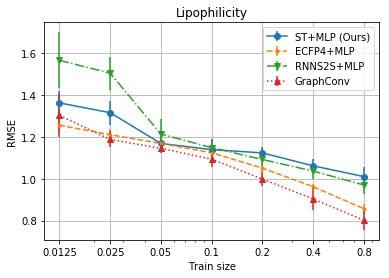

In [77]:
plt.figure(figsize=(6,4))
res_3_1 = dict_to_rmse(scores_st)
res_3_2 = dict_to_rmse(scores_ecfp)
res_3_3 = dict_to_rmse(scores_rnn)
res_3_4 = dict_to_rmse(scores_gc)
res_3_5 = dict_to_rmse(scores_bert)
plt.errorbar(r, res_3_1[0], yerr=res_3_1[1], fmt='o-', label='ST+MLP (Ours)')
plt.errorbar(r, res_3_2[0], yerr=res_3_2[1], fmt='.--', label='ECFP4+MLP')
plt.errorbar(r, res_3_3[0], yerr=res_3_3[1], fmt='v-.', label='RNNS2S+MLP')
plt.errorbar(r, res_3_4[0], yerr=res_3_4[1], fmt='^:', label='GraphConv')
#plt.errorbar(r, res_3_5[0], yerr=res_3_5[1], fmt='o-', label='')
plt.xlabel('Train size')
plt.ylabel('RMSE')
plt.xscale('log')
plt.xticks(r, r)
plt.title('Lipophilicity')
plt.legend()
plt.grid()
plt.show()

In [47]:
print('ST+MLP (Ours):', np.mean(rmse_1[0]))
print('ECFP4+MLP    :', np.mean(rmse_2[0]))
print('RNNS2S+MLP   :', np.mean(rmse_3[0]))
print('GraphConv    :', np.mean(rmse_4[0]))
print('BertFP+MLP   :', np.mean(rmse_5[0]))

ST+MLP (Ours): 1.169013876251099
ECFP4+MLP    : 1.0900040762005774
RNNS2S+MLP   : 1.2190227799182778
GraphConv    : 1.0619531408440506
BertFP+MLP   : 1.2059219452339625


# Biochemistry
## MUV

In [78]:
scores_st = [
{'auc mean': 0.0017335375503279577, 'auc std': 8.288996720512347e-05},
{'auc mean': 0.0025805688671491417, 'auc std': 0.000670080595910785},
{'auc mean': 0.003159505491407609, 'auc std': 0.001041083363598049},
{'auc mean': 0.007896562363993064, 'auc std': 0.002325617467805242},
{'auc mean': 0.009137891290853841, 'auc std': 0.0027659502543736897},
{'auc mean': 0.01382557926523403, 'auc std': 0.005862018875758404},
{'auc mean': 0.023029825298708013, 'auc std': 0.008997661713549966}
]
scores_ecfp = [
{'auc mean': 0.0022181961631041196, 'auc std': 4.397035321373162e-05},
{'auc mean': 0.010256923576680345, 'auc std': 0.004200252646055124},
{'auc mean': 0.009357011284886738, 'auc std': 0.0035729453685806522},
{'auc mean': 0.023985972228104942, 'auc std': 0.006940933161308397},
{'auc mean': 0.03533633524999891, 'auc std': 0.006898272998302227},
{'auc mean': 0.06218030360270412, 'auc std': 0.008688507334103052},
{'auc mean': 0.1070137217540055, 'auc std': 0.022559116213062138}
]
scores_rnn = [
{'auc mean': 0.002765855247617432, 'auc std': 0.0002153396389107669},
{'auc mean': 0.0036739954143430046, 'auc std': 0.0013241874142129418},
{'auc mean': 0.004560044904293777, 'auc std': 0.0015448114068087513},
{'auc mean': 0.0074651701433578205, 'auc std': 0.00254163617852841},
{'auc mean': 0.009181132220160041, 'auc std': 0.003553903256273968},
{'auc mean': 0.012842807356186717, 'auc std': 0.003599612373533911},
{'auc mean': 0.02673075155575853, 'auc std': 0.011771354835709888}
]
scores_gc = [
{'auc mean': 0.002366075760270468, 'auc std': 0.0004538477999893313},
{'auc mean': 0.0022078113610145265, 'auc std': 0.0002298944849634541},
{'auc mean': 0.0037061673491821504, 'auc std': 0.0008181004617674031},
{'auc mean': 0.0040381656257766655, 'auc std': 0.0008454612569763927},
{'auc mean': 0.0046294509752909455, 'auc std': 0.0009654014033996693},
{'auc mean': 0.005142536846654698, 'auc std': 0.002167760911437173},
{'auc mean': 0.006497387379580959, 'auc std': 0.005132898301294616}
]
scores_bert = [
{'auc mean': 0.0019874020866809646, 'auc std': 0.00012003650661377106},
{'auc mean': 0.0024708865557261346, 'auc std': 0.0005639769511779698},
{'auc mean': 0.0026159427369227346, 'auc std': 0.0009698213284911623},
{'auc mean': 0.004135827896598424, 'auc std': 0.001198704027958092},
{'auc mean': 0.0046167588894726564, 'auc std': 0.0009467523206756325},
{'auc mean': 0.005029406755939597, 'auc std': 0.0006358456694826953},
{'auc mean': 0.007417726283911496, 'auc std': 0.0016720071913870027}
]

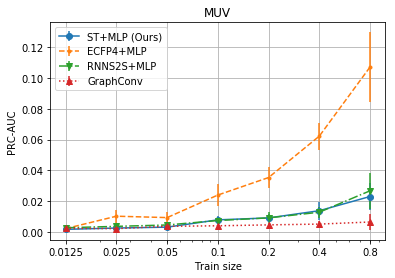

In [79]:
plt.figure(figsize=(6,4))
res_4_1 = dict_to_auc(scores_st)
res_4_2 = dict_to_auc(scores_ecfp)
res_4_3 = dict_to_auc(scores_rnn)
res_4_4 = dict_to_auc(scores_gc)
res_4_5 = dict_to_auc(scores_bert)
plt.errorbar(r, res_4_1[0], yerr=res_4_1[1], fmt='o-', label='ST+MLP (Ours)')
plt.errorbar(r, res_4_2[0], yerr=res_4_2[1], fmt='.--', label='ECFP4+MLP')
plt.errorbar(r, res_4_3[0], yerr=res_4_3[1], fmt='v-.', label='RNNS2S+MLP')
plt.errorbar(r, res_4_4[0], yerr=res_4_4[1], fmt='^:', label='GraphConv')
#plt.errorbar(r, res_4_5[0], yerr=res_4_5[1], fmt='o-', label='')
plt.xlabel('Train size')
plt.ylabel('PRC-AUC')
plt.xscale('log')
plt.xticks(r, r)
plt.title('MUV')
plt.legend()
plt.grid()
plt.show()

In [17]:
print('ST+MLP (Ours):', np.mean(auc_1[0]))
print('ECFP4+MLP    :', np.mean(auc_2[0]))
print('RNNS2S+MLP   :', np.mean(auc_3[0]))
print('GraphConv    :', np.mean(auc_4[0]))
print('BertFP+MLP   :', np.mean(auc_5[0]))

ST+MLP (Ours): 0.008766210018239094
ECFP4+MLP    : 0.035764066265640666
RNNS2S+MLP   : 0.009602822405959619
GraphConv    : 0.0040839421853957735
BertFP+MLP   : 0.004039135886464573


## HIV

In [116]:
scores_st = [
{'auc mean': 0.5976262926889542, 'auc std': 0.03579093374360708},
{'auc mean': 0.6323734547198729, 'auc std': 0.02108332894832721},
{'auc mean': 0.6591255845314171, 'auc std': 0.021955978049908877},
{'auc mean': 0.6939110035882251, 'auc std': 0.016698754522384056},
{'auc mean': 0.7134198269070403, 'auc std': 0.010201478272707365},
{'auc mean': 0.7344584089019738, 'auc std': 0.009402089148309683},
{'auc mean': 0.7530270386211833, 'auc std': 0.014260430683672725}
]
scores_ecfp = [
{'auc mean': 0.563763476646091, 'auc std': 0.04793740061789739},
{'auc mean': 0.6084993676666952, 'auc std': 0.03095860948054148},
{'auc mean': 0.663516786233209, 'auc std': 0.014285121222973821},
{'auc mean': 0.7017281389123037, 'auc std': 0.009831246617193107},
{'auc mean': 0.7457630855006574, 'auc std': 0.006481691881209791},
{'auc mean': 0.77975386640347, 'auc std': 0.006372212100030508},
{'auc mean': 0.8160612792871895, 'auc std': 0.016513397859882258}
]
scores_rnn = [
{'auc mean': 0.6098477756348614, 'auc std': 0.02716138712537457},
{'auc mean': 0.634419126161075, 'auc std': 0.018587064399343493},
{'auc mean': 0.6558364753408517, 'auc std': 0.01908470161513702},
{'auc mean': 0.6814602507239775, 'auc std': 0.013703095589888711},
{'auc mean': 0.7022542175175434, 'auc std': 0.00944552220627052},
{'auc mean': 0.7286772527262663, 'auc std': 0.010733282123696383},
{'auc mean': 0.7588300143038191, 'auc std': 0.014668057074799323}
]
scores_gc = [
{'auc std': 0.05080867095348987, 'auc mean': 0.6343112315674181},
{'auc std': 0.020073621230965948, 'auc mean': 0.682965632176822},
{'auc std': 0.013733146772630893, 'auc mean': 0.7113801223605074},
{'auc std': 0.00967941012248717, 'auc mean': 0.7231228698056307},
{'auc std': 0.013525661229518935, 'auc mean': 0.7444346641952958},
{'auc std': 0.012750085978687807, 'auc mean': 0.7685731528035467},
{'auc std': 0.014853725161847133, 'auc mean': 0.796026593546137}
]
scores_bert = [
{'auc mean': 0.6358831968791019, 'auc std': 0.026160360279364376},
{'auc mean': 0.6600626232052511, 'auc std': 0.01198939527851428},
{'auc mean': 0.6701859670863104, 'auc std': 0.008699714680064388},
{'auc mean': 0.683390765064678, 'auc std': 0.008329895622390684},
{'auc mean': 0.6905485735642622, 'auc std': 0.006784560106001557},
{'auc mean': 0.7009763279203247, 'auc std': 0.010631553956085959},
{'auc mean': 0.715550117207612, 'auc std': 0.014715120476847152}
]

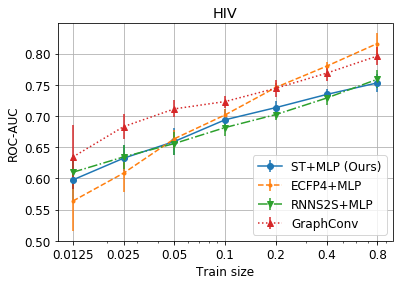

In [117]:
plt.figure(figsize=(6,4))
res_5_1 = dict_to_auc(scores_st)
res_5_2 = dict_to_auc(scores_ecfp)
res_5_3 = dict_to_auc(scores_rnn)
res_5_4 = dict_to_auc(scores_gc)
res_5_5 = dict_to_auc(scores_bert)
plt.errorbar(r, res_5_1[0], yerr=res_5_1[1], fmt='o-', label='ST+MLP (Ours)')
plt.errorbar(r, res_5_2[0], yerr=res_5_2[1], fmt='.--', label='ECFP4+MLP')
plt.errorbar(r, res_5_3[0], yerr=res_5_3[1], fmt='v-.', label='RNNS2S+MLP')
plt.errorbar(r, res_5_4[0], yerr=res_5_4[1], fmt='^:', label='GraphConv')
#plt.errorbar(r, res_5_5[0], yerr=res_5_5[1], fmt='o-', label='')
plt.xlabel('Train size')
plt.ylabel('ROC-AUC')
plt.xscale('log')
plt.xticks(r, r)
plt.title('HIV')
plt.legend()
plt.grid()
plt.show()

In [33]:
print('ST+MLP (Ours):', np.mean(auc_1[0]))
print('ECFP4+MLP    :', np.mean(auc_2[0]))
print('RNNS2S+MLP   :', np.mean(auc_3[0]))
print('GraphConv    :', np.mean(auc_4[0]))
print('BertFP+MLP   :', np.mean(auc_5[0]))

ST+MLP (Ours): 0.6834202299940951
ECFP4+MLP    : 0.697012285807088
RNNS2S+MLP   : 0.6816178732011992
GraphConv    : 0.7229734666364797
BertFP+MLP   : 0.6795139387039343


## BACE

In [118]:
scores_st = [
{'auc mean': 0.5916079452430238, 'auc std': 0.0525840624540231},
{'auc mean': 0.6224383403509031, 'auc std': 0.031943157030004464},
{'auc mean': 0.6839151694447854, 'auc std': 0.0343080646046333},
{'auc mean': 0.7265169027548448, 'auc std': 0.025865711293704522},
{'auc mean': 0.7753986269972573, 'auc std': 0.016742446037013418},
{'auc mean': 0.7807202033285271, 'auc std': 0.02344691441296362},
{'auc mean': 0.849997804128239, 'auc std': 0.012312074771296606}
]
scores_ecfp = [
{'auc mean': 0.6299620354275904, 'auc std': 0.050064850038022114},
{'auc mean': 0.6969026339936509, 'auc std': 0.04028410459645388},
{'auc mean': 0.7364717501076752, 'auc std': 0.02530942379913975},
{'auc mean': 0.7847283175458417, 'auc std': 0.018398889354123107},
{'auc mean': 0.821187072997796, 'auc std': 0.01676016416578495},
{'auc mean': 0.8488946455191962, 'auc std': 0.008248150865819617},
{'auc mean': 0.8682454984628898, 'auc std': 0.015548778463387536}
]
scores_rnn = [
{'auc mean': 0.582567400413995, 'auc std': 0.04280790016755629},
{'auc mean': 0.6344276548983624, 'auc std': 0.03381583945295958},
{'auc mean': 0.6776480802623963, 'auc std': 0.033850761210358356},
{'auc mean': 0.7395557052229077, 'auc std': 0.016619885405124386},
{'auc mean': 0.7896572714730923, 'auc std': 0.013972109845764507},
{'auc mean': 0.7692541362203378, 'auc std': 0.012970396846871084},
{'auc mean': 0.8291567852437417, 'auc std': 0.020508129855815155}
]
scores_gc = [
{'auc mean': 0.611985673340637, 'auc std': 0.05493310761991158},
{'auc mean': 0.6280243198709566, 'auc std': 0.04883073418862016},
{'auc mean': 0.6960873602742459, 'auc std': 0.03229879651580333},
{'auc mean': 0.7589524659926619, 'auc std': 0.023287082928806237},
{'auc mean': 0.8083917156732647, 'auc std': 0.015299247847678865},
{'auc mean': 0.8410463005403065, 'auc std': 0.01104927811577262},
{'auc mean': 0.862759688481872, 'auc std': 0.021925818242114765}
]
scores_bert = [
{'auc mean': 0.576825472956891, 'auc std': 0.051589652074179204},
{'auc mean': 0.603195923396257, 'auc std': 0.0584623250755939},
{'auc mean': 0.6607868186008259, 'auc std': 0.04092274370568475},
{'auc mean': 0.6960517511080212, 'auc std': 0.06755893752884638},
{'auc mean': 0.7220647806658348, 'auc std': 0.018398236241281854},
{'auc mean': 0.6963501063075833, 'auc std': 0.02542892283824217},
{'auc mean': 0.7378787878787879, 'auc std': 0.029773901243748728}
]

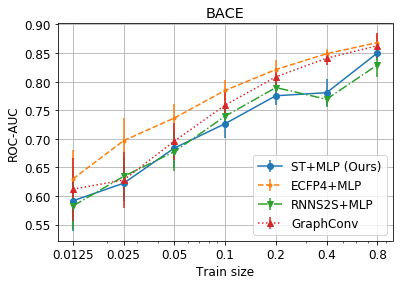

In [119]:
plt.figure(figsize=(6,4))
res_6_1 = dict_to_auc(scores_st)
res_6_2 = dict_to_auc(scores_ecfp)
res_6_3 = dict_to_auc(scores_rnn)
res_6_4 = dict_to_auc(scores_gc)
res_6_5 = dict_to_auc(scores_bert)
plt.errorbar(r, res_6_1[0], yerr=res_6_1[1], fmt='o-', label='ST+MLP (Ours)')
plt.errorbar(r, res_6_2[0], yerr=res_6_2[1], fmt='.--', label='ECFP4+MLP')
plt.errorbar(r, res_6_3[0], yerr=res_6_3[1], fmt='v-.', label='RNNS2S+MLP')
plt.errorbar(r, res_6_4[0], yerr=res_6_4[1], fmt='^:', label='GraphConv')
#plt.errorbar(r, res_6_5[0], yerr=res_6_5[1], fmt='o-', label='')
plt.xlabel('Train size')
plt.ylabel('ROC-AUC')
plt.xscale('log')
plt.xticks(r, r)
plt.title('BACE')
plt.legend()
plt.grid()
plt.show()

In [52]:
print('ST+MLP (Ours):', np.mean(auc_1[0]))
print('ECFP4+MLP    :', np.mean(auc_2[0]))
print('RNNS2S+MLP   :', np.mean(auc_3[0]))
print('GraphConv    :', np.mean(auc_4[0]))
print('BertFP+MLP   :', np.mean(auc_5[0]))

ST+MLP (Ours): 0.7186564274639401
ECFP4+MLP    : 0.7694845648649487
RNNS2S+MLP   : 0.7174667191049762
GraphConv    : 0.7438925034534207
BertFP+MLP   : 0.6704505201306002


# Physiology
## BBBP

In [120]:
scores_st = [
{'auc mean': 0.8347635956857836, 'auc std': 0.03655667894587934},
{'auc mean': 0.8665631495870432, 'auc std': 0.019857283458358032},
{'auc mean': 0.8853260145935845, 'auc std': 0.02346809873291377},
{'auc mean': 0.9104212113801256, 'auc std': 0.009691814726953234},
{'auc mean': 0.9260329639454264, 'auc std': 0.009046904166355963},
{'auc mean': 0.9327153338224505, 'auc std': 0.00640613201510519},
{'auc mean': 0.9410526662494647, 'auc std': 0.008820456842932357}
]
scores_ecfp = [
{'auc mean': 0.6233275665975664, 'auc std': 0.07152790559665126},
{'auc mean': 0.6620199951039291, 'auc std': 0.05188082443039691},
{'auc mean': 0.7322774966099309, 'auc std': 0.030639432892693365},
{'auc mean': 0.764260100238624, 'auc std': 0.022598618056672664},
{'auc mean': 0.8093911682871102, 'auc std': 0.018374052902075565},
{'auc mean': 0.8510450053418804, 'auc std': 0.00943495257087519},
{'auc mean': 0.8779755942841879, 'auc std': 0.01720593557596936}
]
scores_rnn = [
{'auc mean': 0.7911813579705199, 'auc std': 0.041783380559957825},
{'auc mean': 0.841184513289092, 'auc std': 0.019145977936395886},
{'auc mean': 0.8578805942196294, 'auc std': 0.020174458806343432},
{'auc mean': 0.8976094399608705, 'auc std': 0.010577078969817744},
{'auc mean': 0.9159243787754834, 'auc std': 0.008341542609256257},
{'auc mean': 0.9348222670579605, 'auc std': 0.006084300148200208},
{'auc mean': 0.951493692566121, 'auc std': 0.00789456539422481}
]
scores_gc = [
{'auc mean': 0.6283862098979413, 'auc std': 0.10035561294474928},
{'auc mean': 0.7001804757013901, 'auc std': 0.05661417539596054},
{'auc mean': 0.782625900793585, 'auc std': 0.019081820444551884},
{'auc mean': 0.8167913661759449, 'auc std': 0.02112117475176503},
{'auc mean': 0.8528584286250934, 'auc std': 0.009294948455672195},
{'auc mean': 0.8825663234821433, 'auc std': 0.01021126962366743},
{'auc mean': 0.9020596927921627, 'auc std': 0.022184162248440883}
]
scores_bert = [
{'auc mean': 0.807965644450945, 'auc std': 0.04809932907190572},
{'auc mean': 0.8447807938995788, 'auc std': 0.026583025519905542},
{'auc mean': 0.8520615962226993, 'auc std': 0.027005851228501833},
{'auc mean': 0.8450879595663162, 'auc std': 0.017258848000867657},
{'auc mean': 0.8792468246688319, 'auc std': 0.012678991677955295},
{'auc mean': 0.9000940939104917, 'auc std': 0.013108911207265199},
{'auc mean': 0.9192714337472415, 'auc std': 0.012230716194152074}
]

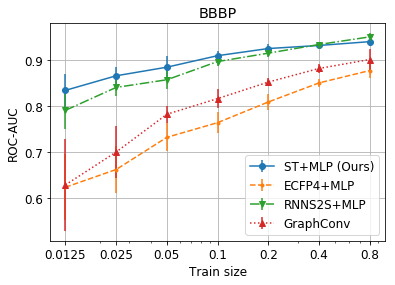

In [121]:
plt.figure(figsize=(6,4))
res_7_1 = dict_to_auc(scores_st)
res_7_2 = dict_to_auc(scores_ecfp)
res_7_3 = dict_to_auc(scores_rnn)
res_7_4 = dict_to_auc(scores_gc)
res_7_5 = dict_to_auc(scores_bert)
plt.errorbar(r, res_7_1[0], yerr=res_7_1[1], fmt='o-', label='ST+MLP (Ours)')
plt.errorbar(r, res_7_2[0], yerr=res_7_2[1], fmt='.--', label='ECFP4+MLP')
plt.errorbar(r, res_7_3[0], yerr=res_7_3[1], fmt='v-.', label='RNNS2S+MLP')
plt.errorbar(r, res_7_4[0], yerr=res_7_4[1], fmt='^:', label='GraphConv')
#plt.errorbar(r, res_7_5[0], yerr=res_7_5[1], fmt='o-', label='')
plt.xlabel('Train size')
plt.ylabel('ROC-AUC')
plt.xscale('log')
plt.xticks(r, r)
plt.title('BBBP')
plt.legend()
plt.grid()
plt.show()

In [36]:
print('ST+MLP (Ours):', np.mean(auc_1[0]))
print('ECFP4+MLP    :', np.mean(auc_2[0]))
print('RNNS2S+MLP   :', np.mean(auc_3[0]))
print('GraphConv    :', np.mean(auc_4[0]))
print('BertFP+MLP   :', np.mean(auc_5[0]))

ST+MLP (Ours): 0.899553562180554
ECFP4+MLP    : 0.7600424180661757
RNNS2S+MLP   : 0.884299463405668
GraphConv    : 0.7950669139240373
BertFP+MLP   : 0.8640726209237293


## Tox21

In [122]:
scores_st = [
{'auc mean': 0.636819427877498, 'auc std': 0.01676340515187386},
{'auc mean': 0.6684521844401683, 'auc std': 0.012557862868813125},
{'auc mean': 0.6846717726308414, 'auc std': 0.00864439698734144},
{'auc mean': 0.7079399575844314, 'auc std': 0.00495250460888231},
{'auc mean': 0.7291339046290648, 'auc std': 0.005785632700826855},
{'auc mean': 0.7482154551803918, 'auc std': 0.004880373911126395},
{'auc mean': 0.7656235408192239, 'auc std': 0.007142937854245916}
]
scores_ecfp = [
{'auc mean': 0.48852397825172256, 'auc std': 0.011588580474552695},
{'auc mean': 0.5201946445247954, 'auc std': 0.011913936013996974},
{'auc mean': 0.575155846321433, 'auc std': 0.007810621158148587},
{'auc mean': 0.6140548327403642, 'auc std': 0.005187929036653902},
{'auc mean': 0.6600481309136884, 'auc std': 0.004687217174901597},
{'auc mean': 0.7065901958998645, 'auc std': 0.005143655434537728},
{'auc mean': 0.7472649974128428, 'auc std': 0.01234630120358285}
]
scores_rnn = [
{'auc mean': 0.6425397056215969, 'auc std': 0.013041654093995379},
{'auc mean': 0.6596280092234303, 'auc std': 0.010864263924597203},
{'auc mean': 0.674127567558211, 'auc std': 0.010145977744031602},
{'auc mean': 0.7024737660919766, 'auc std': 0.004748314014680404},
{'auc mean': 0.7234471851312214, 'auc std': 0.005289071215204893},
{'auc mean': 0.7423479849618777, 'auc std': 0.004875955625707662},
{'auc mean': 0.7708396064574479, 'auc std': 0.007089837444937812}
]
scores_gc = [
{'auc std': 0.02183641325412813, 'auc mean': 0.5342075951225206},
{'auc std': 0.013597547716178713, 'auc mean': 0.596726727579882},
{'auc std': 0.01739773600308084, 'auc mean': 0.6479551141406318},
{'auc std': 0.010048298873178433, 'auc mean': 0.6989388187335792},
{'auc std': 0.0068505417486006935, 'auc mean': 0.7411389151580904},
{'auc std': 0.007137931708650632, 'auc mean': 0.7798569585394814},
{'auc std': 0.011653068267497783, 'auc mean': 0.8127077196881753}
]
scores_bert = [
{'auc mean': 0.6010158416922666, 'auc std': 0.023240420841334274},
{'auc mean': 0.609843745459462, 'auc std': 0.02325644212925572},
{'auc mean': 0.6932080977569708, 'auc std': 0.009283212001007193},
{'auc mean': 0.7262284131046333, 'auc std': 0.006020303461160268},
{'auc mean': 0.7442901406703255, 'auc std': 0.004469625227936093},
{'auc mean': 0.7580719165187659, 'auc std': 0.004558186870771946},
{'auc mean': 0.7719572345425985, 'auc std': 0.00501484117852729}
]

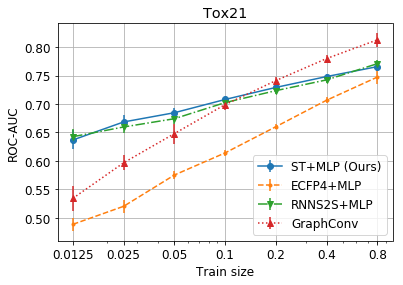

In [123]:
plt.figure(figsize=(6,4))
res_8_1 = dict_to_auc(scores_st)
res_8_2 = dict_to_auc(scores_ecfp)
res_8_3 = dict_to_auc(scores_rnn)
res_8_4 = dict_to_auc(scores_gc)
res_8_5 = dict_to_auc(scores_bert)
plt.errorbar(r, res_8_1[0], yerr=res_8_1[1], fmt='o-', label='ST+MLP (Ours)')
plt.errorbar(r, res_8_2[0], yerr=res_8_2[1], fmt='.--', label='ECFP4+MLP')
plt.errorbar(r, res_8_3[0], yerr=res_8_3[1], fmt='v-.', label='RNNS2S+MLP')
plt.errorbar(r, res_8_4[0], yerr=res_8_4[1], fmt='^:', label='GraphConv')
#plt.errorbar(r, res_8_5[0], yerr=res_8_5[1], fmt='o-', label='')
plt.xlabel('Train size')
plt.ylabel('ROC-AUC')
plt.xscale('log')
plt.xticks(r, r)
plt.title('Tox21')
plt.legend()
plt.grid()
plt.show()

In [19]:
print('ST+MLP (Ours):', np.mean(auc_1[0]))
print('ECFP4+MLP    :', np.mean(auc_2[0]))
print('RNNS2S+MLP   :', np.mean(auc_3[0]))
print('GraphConv    :', np.mean(auc_4[0]))
print('BertFP+MLP   :', np.mean(auc_5[0]))

ST+MLP (Ours): 0.7058366061659457
ECFP4+MLP    : 0.6159760894378159
RNNS2S+MLP   : 0.702200546435109
GraphConv    : 0.6873616927089087
BertFP+MLP   : 0.7006593413921461


## SIDER

In [124]:
scores_st = [
{'auc mean': 0.5256172998491813, 'auc std': 0.009327074848106227},
{'auc mean': 0.5324077768793416, 'auc std': 0.011787773165028652},
{'auc mean': 0.5441177379245871, 'auc std': 0.006966903765198338},
{'auc mean': 0.5583409954583286, 'auc std': 0.005102843754746479},
{'auc mean': 0.5687384209552709, 'auc std': 0.005478971601816549},
{'auc mean': 0.5824164366710604, 'auc std': 0.005062924664440607},
{'auc mean': 0.6043440615316215, 'auc std': 0.008727982077987785}
]
scores_ecfp = [
{'auc mean': 0.5514793112380094, 'auc std': 0.004530055245347764},
{'auc mean': 0.5589578501366791, 'auc std': 0.004534084472119589},
{'auc mean': 0.570089506491246, 'auc std': 0.005035395945620036},
{'auc mean': 0.582829188677217, 'auc std': 0.004262473585821782},
{'auc mean': 0.5974733632037447, 'auc std': 0.0033663020891329634},
{'auc mean': 0.6154061633807567, 'auc std': 0.005271349325392699},
{'auc mean': 0.6363932687272557, 'auc std': 0.008875670046783225}
]
scores_rnn = [
{'auc mean': 0.5247333844786712, 'auc std': 0.0071151371866655065},
{'auc mean': 0.528438737962658, 'auc std': 0.0067549726230368016},
{'auc mean': 0.5403389640550995, 'auc std': 0.0064322762469103},
{'auc mean': 0.5500568705565965, 'auc std': 0.005951971070907419},
{'auc mean': 0.5662190224495347, 'auc std': 0.004801851693343641},
{'auc mean': 0.5845393377043444, 'auc std': 0.004621508328278725},
{'auc mean': 0.6091705950741559, 'auc std': 0.006388730134388776}
]
scores_gc = [
{'auc std': 0.008434614052576818, 'auc mean': 0.5291169243540773},
{'auc std': 0.006665791828304381, 'auc mean': 0.5274059138650409},
{'auc std': 0.007821486191076858, 'auc mean': 0.5338999924818719},
{'auc std': 0.007789634679872869, 'auc mean': 0.5462240133350073},
{'auc std': 0.006370035325254813, 'auc mean': 0.5605487301897695},
{'auc std': 0.007905088291201193, 'auc mean': 0.5869302140824767},
{'auc std': 0.009919981893441888, 'auc mean': 0.6135745320176337}
]
scores_bert = [
{'auc mean': 0.5159862072396973, 'auc std': 0.010242381425175107},
{'auc mean': 0.5319403529308495, 'auc std': 0.006684946733821753},
{'auc mean': 0.5362092315996206, 'auc std': 0.007952321933657141},
{'auc mean': 0.5488136946934671, 'auc std': 0.0063319851307063035},
{'auc mean': 0.5732072272644789, 'auc std': 0.004495625316498007},
{'auc mean': 0.5885331910521647, 'auc std': 0.0046245790834997386},
{'auc mean': 0.597753895604088, 'auc std': 0.007893792418320174}
]

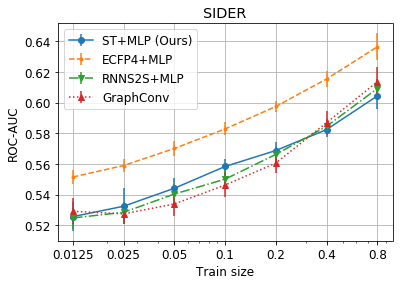

In [125]:
plt.figure(figsize=(6,4))
res_9_1 = dict_to_auc(scores_st)
res_9_2 = dict_to_auc(scores_ecfp)
res_9_3 = dict_to_auc(scores_rnn)
res_9_4 = dict_to_auc(scores_gc)
res_9_5 = dict_to_auc(scores_bert)
plt.errorbar(r, res_9_1[0], yerr=res_9_1[1], fmt='o-', label='ST+MLP (Ours)')
plt.errorbar(r, res_9_2[0], yerr=res_9_2[1], fmt='.--', label='ECFP4+MLP')
plt.errorbar(r, res_9_3[0], yerr=res_9_3[1], fmt='v-.', label='RNNS2S+MLP')
plt.errorbar(r, res_9_4[0], yerr=res_9_4[1], fmt='^:', label='GraphConv')
#plt.errorbar(r, res_9_5[0], yerr=res_9_5[1], fmt='o-', label='')
plt.xlabel('Train size')
plt.ylabel('ROC-AUC')
plt.xscale('log')
plt.xticks(r, r)
plt.title('SIDER')
plt.legend()
plt.grid()
plt.show()

In [17]:
print('ST+MLP (Ours):', np.mean(auc_1[0]))
print('ECFP4+MLP    :', np.mean(auc_2[0]))
print('RNNS2S+MLP   :', np.mean(auc_3[0]))
print('GraphConv    :', np.mean(auc_4[0]))
print('BertFP+MLP   :', np.mean(auc_5[0]))

ST+MLP (Ours): 0.5594261041813416
ECFP4+MLP    : 0.5875183788364156
RNNS2S+MLP   : 0.5576424160401515
GraphConv    : 0.5568143314751254
BertFP+MLP   : 0.5560634000549094


## ClinTox

In [126]:
scores_st = [
{'auc mean': 0.9302798278197567, 'auc std': 0.037199597680700046},
{'auc mean': 0.9481876623231443, 'auc std': 0.014987221801032081},
{'auc mean': 0.9635442452711157, 'auc std': 0.005898416483958611},
{'auc mean': 0.9683355930164179, 'auc std': 0.007479499787458779},
{'auc mean': 0.973179667243282, 'auc std': 0.0051722411301356125},
{'auc mean': 0.9787603493047028, 'auc std': 0.0056559923801398106},
{'auc mean': 0.9818157002888336, 'auc std': 0.008691620113166038}
]
scores_ecfp = [
{'auc mean': 0.38509490517204775, 'auc std': 0.019231545721569907},
{'auc mean': 0.399556259993759, 'auc std': 0.02044899342504069},
{'auc mean': 0.4310613764705873, 'auc std': 0.02287156837901825},
{'auc mean': 0.4629432890212433, 'auc std': 0.025173192954107058},
{'auc mean': 0.5571635505306899, 'auc std': 0.018318737662891337},
{'auc mean': 0.6516973943717742, 'auc std': 0.02509846019574034},
{'auc mean': 0.7206206172291671, 'auc std': 0.0424156411616633}
]
scores_rnn = [
{'auc mean': 0.7930007022764917, 'auc std': 0.0613547976950411},
{'auc mean': 0.8398416752631075, 'auc std': 0.05313929274735127},
{'auc mean': 0.8918712248087421, 'auc std': 0.0358716683752473},
{'auc mean': 0.909707764115353, 'auc std': 0.036399113439209},
{'auc mean': 0.9548524111469519, 'auc std': 0.007347789978775678},
{'auc mean': 0.9633679137574311, 'auc std': 0.005764178479975666},
{'auc mean': 0.9741151392065991, 'auc std': 0.015390594532246291}
]
scores_gc = [
{'auc std': 0.04923293871868106, 'auc mean': 0.47788329156982556},
{'auc std': 0.050804999531372, 'auc mean': 0.4827146223468423},
{'auc std': 0.06175337106056708, 'auc mean': 0.506507255252547},
{'auc std': 0.05065009854853338, 'auc mean': 0.5618639224309648},
{'auc std': 0.03260581401191265, 'auc mean': 0.6454794289483705},
{'auc std': 0.03364414075056592, 'auc mean': 0.7403534803189631},
{'auc std': 0.0319725421454909, 'auc mean': 0.8192952722741552}
]
scores_bert = [
{'auc mean': 0.8762144193346793, 'auc std': 0.039801853951623764},
{'auc mean': 0.9037450381431951, 'auc std': 0.03222325378726534},
{'auc mean': 0.9155706260829687, 'auc std': 0.03342574576260571},
{'auc mean': 0.920394284832922, 'auc std': 0.03468913007798735},
{'auc mean': 0.9748829202105055, 'auc std': 0.004033998016908116},
{'auc mean': 0.977721278647706, 'auc std': 0.0047296281158840554},
{'auc mean': 0.9809146078526482, 'auc std': 0.010926250751335447}
]

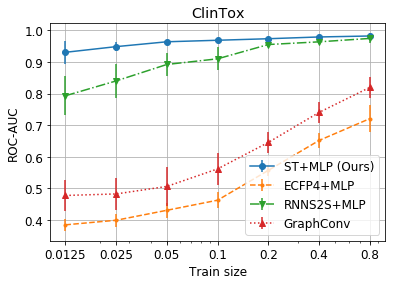

In [127]:
plt.figure(figsize=(6,4))
res_10_1 = dict_to_auc(scores_st)
res_10_2 = dict_to_auc(scores_ecfp)
res_10_3 = dict_to_auc(scores_rnn)
res_10_4 = dict_to_auc(scores_gc)
res_10_5 = dict_to_auc(scores_bert)
plt.errorbar(r, res_10_1[0], yerr=res_10_1[1], fmt='o-', label='ST+MLP (Ours)')
plt.errorbar(r, res_10_2[0], yerr=res_10_2[1], fmt='.--', label='ECFP4+MLP')
plt.errorbar(r, res_10_3[0], yerr=res_10_3[1], fmt='v-.', label='RNNS2S+MLP')
plt.errorbar(r, res_10_4[0], yerr=res_10_4[1], fmt='^:', label='GraphConv')
#plt.errorbar(r, res_10_5[0], yerr=res_10_5[1], fmt='o-', label='')
plt.xlabel('Train size')
plt.ylabel('ROC-AUC')
plt.xscale('log')
plt.xticks(r, r)
plt.title('ClinTox')
plt.legend()
plt.grid()
plt.show()

In [24]:
print('ST+MLP (Ours):', np.mean(auc_1[0]))
print('ECFP4+MLP    :', np.mean(auc_2[0]))
print('RNNS2S+MLP   :', np.mean(auc_3[0]))
print('GraphConv    :', np.mean(auc_4[0]))
print('BertFP+MLP   :', np.mean(auc_5[0]))

ST+MLP (Ours): 0.963443292181036
ECFP4+MLP    : 0.5154481989698956
RNNS2S+MLP   : 0.903822404367811
GraphConv    : 0.6048710390202384
BertFP+MLP   : 0.9356347393006607


# All

In [135]:
def subplot(ax, res1, res2, res3, res4, metric, title, color):
    ax.errorbar(r, res1[0], yerr=res1[1], fmt='o-', label='ST+MLP (Ours)')
    ax.errorbar(r, res2[0], yerr=res2[1], fmt='.--', label='ECFP4+MLP')
    ax.errorbar(r, res3[0], yerr=res3[1], fmt='v-.', label='RNNS2S+MLP')
    ax.errorbar(r, res4[0], yerr=res4[1], fmt='^:', label='GraphConv')
    ax.set_ylabel(metric)
    ax.set_xscale('log')
    ax.set_xticks(r)
    ax.set_xticklabels([])
    ax.grid()
    ax.set_facecolor(color)
    ax.set_title(title)

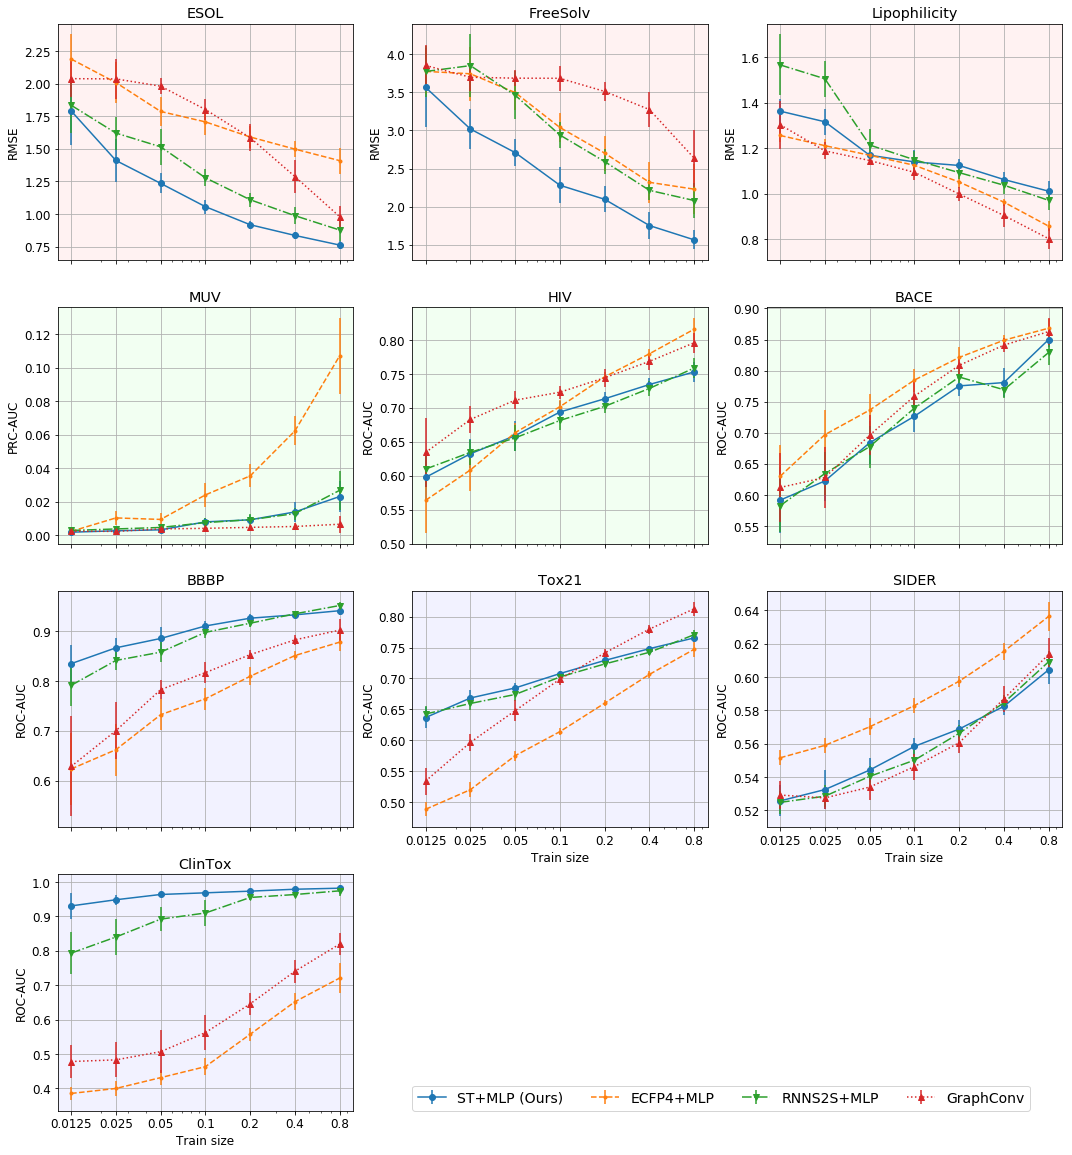

In [154]:
#fig = plt.figure(figsize=(12,25))
fig = plt.figure(figsize=(18,20))
plt.rcParams['font.size'] = 12

ax = fig.add_subplot(4,3,1)
subplot(ax, res_1_1, res_1_2, res_1_3, res_1_4, 'RMSE', 'ESOL', (1,0,0,0.05))

ax = fig.add_subplot(4,3,2)
subplot(ax, res_2_1, res_2_2, res_2_3, res_2_4, 'RMSE', 'FreeSolv', (1,0,0,0.05))

ax = fig.add_subplot(4,3,3)
subplot(ax, res_3_1, res_3_2, res_3_3, res_3_4, 'RMSE', 'Lipophilicity', (1,0,0,0.05))

ax = fig.add_subplot(4,3,4)
subplot(ax, res_4_1, res_4_2, res_4_3, res_4_4, 'PRC-AUC', 'MUV', (0,1,0,0.05))

ax = fig.add_subplot(4,3,5)
subplot(ax, res_5_1, res_5_2, res_5_3, res_5_4, 'ROC-AUC', 'HIV', (0,1,0,0.05))

ax = fig.add_subplot(4,3,6)
subplot(ax, res_6_1, res_6_2, res_6_3, res_6_4, 'ROC-AUC', 'BACE', (0,1,0,0.05))

ax = fig.add_subplot(4,3,7)
subplot(ax, res_7_1, res_7_2, res_7_3, res_7_4, 'ROC-AUC', 'BBBP', (0,0,1,0.05))

ax = fig.add_subplot(4,3,8)
subplot(ax, res_8_1, res_8_2, res_8_3, res_8_4, 'ROC-AUC', 'Tox21', (0,0,1,0.05))
ax.set_xlabel('Train size')
ax.set_xticklabels(r)

ax = fig.add_subplot(4,3,9)
subplot(ax, res_9_1, res_9_2, res_9_3, res_9_4, 'ROC-AUC', 'SIDER', (0,0,1,0.05))
ax.set_xlabel('Train size')
ax.set_xticklabels(r)

ax = fig.add_subplot(4,3,10)
subplot(ax, res_10_1, res_10_2, res_10_3, res_10_4, 'ROC-AUC', 'ClinTox', (0,0,1,0.05))
ax.set_xlabel('Train size')
ax.set_xticklabels(r)

ax.legend(loc=(1.2, 0), ncol=4, fontsize=14)
#ax.legend(loc=(-1.05, -0.3), ncol=4)
fig.show()

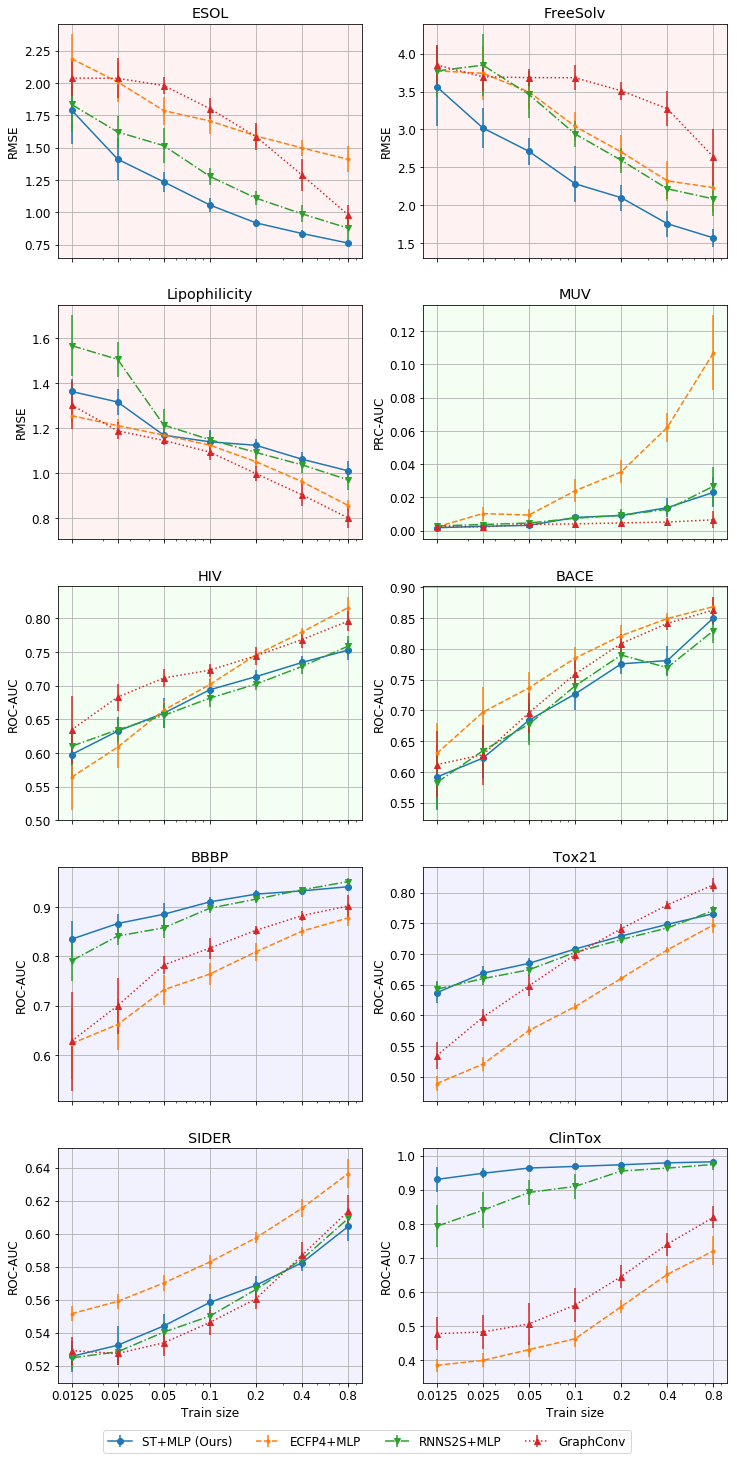

In [152]:
fig = plt.figure(figsize=(12,25))
#fig = plt.figure(figsize=(18,20))
plt.rcParams['font.size'] = 12

ax = fig.add_subplot(5,2,1)
subplot(ax, res_1_1, res_1_2, res_1_3, res_1_4, 'RMSE', 'ESOL', (1,0,0,0.05))

ax = fig.add_subplot(5,2,2)
subplot(ax, res_2_1, res_2_2, res_2_3, res_2_4, 'RMSE', 'FreeSolv', (1,0,0,0.05))

ax = fig.add_subplot(5,2,3)
subplot(ax, res_3_1, res_3_2, res_3_3, res_3_4, 'RMSE', 'Lipophilicity', (1,0,0,0.05))

ax = fig.add_subplot(5,2,4)
subplot(ax, res_4_1, res_4_2, res_4_3, res_4_4, 'PRC-AUC', 'MUV', (0,1,0,0.05))

ax = fig.add_subplot(5,2,5)
subplot(ax, res_5_1, res_5_2, res_5_3, res_5_4, 'ROC-AUC', 'HIV', (0,1,0,0.05))

ax = fig.add_subplot(5,2,6)
subplot(ax, res_6_1, res_6_2, res_6_3, res_6_4, 'ROC-AUC', 'BACE', (0,1,0,0.05))

ax = fig.add_subplot(5,2,7)
subplot(ax, res_7_1, res_7_2, res_7_3, res_7_4, 'ROC-AUC', 'BBBP', (0,0,1,0.05))

ax = fig.add_subplot(5,2,8)
subplot(ax, res_8_1, res_8_2, res_8_3, res_8_4, 'ROC-AUC', 'Tox21', (0,0,1,0.05))

ax = fig.add_subplot(5,2,9)
subplot(ax, res_9_1, res_9_2, res_9_3, res_9_4, 'ROC-AUC', 'SIDER', (0,0,1,0.05))
ax.set_xlabel('Train size')
ax.set_xticklabels(r)

ax = fig.add_subplot(5,2,10)
subplot(ax, res_10_1, res_10_2, res_10_3, res_10_4, 'ROC-AUC', 'ClinTox', (0,0,1,0.05))
ax.set_xlabel('Train size')
ax.set_xticklabels(r)

#ax.legend(loc=(1.5, 0.5), fontsize=16)
ax.legend(loc=(-1.05, -0.3), ncol=4)
fig.show()